# Visualisation Examples

This notebook shows some of the visulisation utility of our toolkit.

The core packages for visualisation are:
### `rasterization`
contains classes for getting visual data as multi-channel tensors and turning them into interpretable RGB images.
Every class has at least a `rasterize` method to get the tensor and a `to_rgb` method to convert it into an image.
A few examples are:
- `BoxRasterizer`: this object renders agents (e.g. vehicles or pedestrians) as oriented 2D boxes
- `SatelliteRasterizer`: this object renders an oriented crop from a satellite map

### `visualization`
contains utilities to draw additional information (e.g. trajectories) onto RGB images. These utilities are commonly used after a `to_rgb` call to add other information to the final visualisation. 
One example is:
- `draw_trajectory`: this function draws 2D trajectories from coordinates and yaws offset on an image


In [1]:
import sys
sys.path.insert(0, "/home/herb/WRK/ken/l5kit_repo/l5kit")

import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import LABELS
from prettytable import PrettyTable

import os

### First, let's configure where our data lives!
The data is expected to live in a folder that can be configured using the `L5KIT_DATA_FOLDER` env variable. You data folder is expected to contain subfolders for the aerial and semantic maps as well as the scenes (`.zarr` files). 
In this example, the env variable is set to the local data folder. You should make sure the path points to the correct location for you.

We built our code to work with a human-readable `yaml` config. This config file holds much useful information, however, we will only focus on a few functionalities concerning loading and visualization here.

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/herb/WRK/ken/data"
# get config
cfg = load_config_data("./visualisation_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'train_data_loader': {'datasets': [{'key': 'sample_scenes/sample.zarr', 'scene_indices': [-1]}], 'perturb_probability': 0, 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'datasets': [{'key': 'sample_scenes/sample.zarr', 'scene_indices': [-1]}], 'perturb_probability': 0, 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 30, 'eval_every_n_steps': 10000}}


### We can look into our current configuration for interesting fields

\- when loaded in python, the `yaml`file is converted into a python `dict`. 

`raster_params` contains all the information related to the transformation of the 3D world onto an image plane:
  - `raster_size`: the image plane size
  - `pixel_size`: how many meters correspond to a pixel
  - `ego_center`: our raster is centered around an agent, we can move the agent in the image plane with this param
  - `map_type`: the rasterizer to be employed. We currently support a satellite-based and a semantic-based one. We will look at the differences further down in this script

In [3]:
print(f'current raster_param: {cfg["raster_params"]}')

current raster_param: {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}


## Load the data

The same config file is also used to load the data. Every split in the data has its own section, and multiple datasets can be used (as a whole or sliced). In this short example we will only use the first dataset from the `sample` set. You can change this by configuring the 'train_data_loader' variable in the config.

You may also have noticed that we're building a `LocalDataManager` object. This will resolve relative paths from the config using the `L5KIT_DATA_FOLDER` env variable we have just set.

In [4]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["train_data_loader"]["datasets"][0]["key"])
# dataset_path = dm.require("sample.zarr")
zarr_dataset = ChunkedDataset(dataset_path)
# d = zarr_dataset(dataset_path)
zarr_dataset.open()
# d.open()

## Working with the raw data

`.zarr` files support most of the traditional numpy array operations. In the following cell we iterate over the frames to get a scatter plot of the AV locations:

getting centroid to plot trajectory: 100%|██████████| 23846/23846 [00:15<00:00, 1578.54it/s]


(-2500.0, 1600.0)

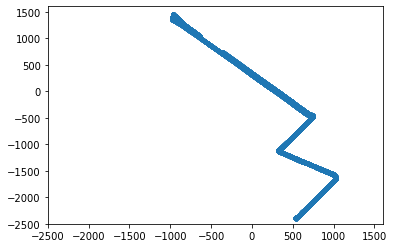

In [5]:
frames = zarr_dataset.frames
coords = np.zeros((len(frames), 2))
for idx_coord, idx_data in enumerate(tqdm(range(len(frames)), desc="getting centroid to plot trajectory")):
    frame = zarr_dataset.frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]


plt.scatter(coords[:, 0], coords[:, 1], marker='.')
axes = plt.gca()
axes.set_xlim([-2500, 1600])
axes.set_ylim([-2500, 1600])

Another easy thing to try is to get an idea of the agents types distribution. 

We can get all the agents `label_probabilities` and get the argmax for each raw. because `.zarr` files map to numpy array we can use all the traditional numpy operations and functions.

In [6]:
agents = zarr_dataset.agents
probabilities = agents["label_probabilities"]
labels_indexes = np.argmax(probabilities, axis=1)
counts = []
for idx_label, label in enumerate(LABELS):
    counts.append(np.sum(labels_indexes == idx_label))
    
table = PrettyTable(field_names=["label", "counts"])
for count, label in zip(counts, LABELS):
    table.add_row([label, count])
print(table)

+------------------------------------+---------+
|               label                |  counts |
+------------------------------------+---------+
|      PERCEPTION_LABEL_NOT_SET      |    0    |
|      PERCEPTION_LABEL_UNKNOWN      | 1265158 |
|     PERCEPTION_LABEL_DONTCARE      |    0    |
|        PERCEPTION_LABEL_CAR        |  489138 |
|        PERCEPTION_LABEL_VAN        |    0    |
|       PERCEPTION_LABEL_TRAM        |    0    |
|        PERCEPTION_LABEL_BUS        |    0    |
|       PERCEPTION_LABEL_TRUCK       |    0    |
| PERCEPTION_LABEL_EMERGENCY_VEHICLE |    0    |
|   PERCEPTION_LABEL_OTHER_VEHICLE   |    0    |
|      PERCEPTION_LABEL_BICYCLE      |    0    |
|    PERCEPTION_LABEL_MOTORCYCLE     |    0    |
|      PERCEPTION_LABEL_CYCLIST      |   6523  |
|   PERCEPTION_LABEL_MOTORCYCLIST    |    0    |
|    PERCEPTION_LABEL_PEDESTRIAN     |  39743  |
|      PERCEPTION_LABEL_ANIMAL       |    0    |
|     AVRESEARCH_LABEL_DONTCARE      |    0    |
+-------------------

## Working with data abstraction

Even though it's absolutely fine to work with the raw data, we also provide classes that abstract data access to offer an easier way to generate inputs and targets.

### Core Objects
Along with the `rasterizer`, our toolkit contains other classes you may want to use while you build your solution. The `dataset` package, for example, already implements `PyTorch` ready datasets, so you can hit the ground running and start coding immediately.

### Dataset package
We will use two classes from the `dataset` package for this example. Both of them can be iterated and return multi-channel images from the rasterizer along with future trajectories offsets and other information.
- `EgoDataset`: this dataset iterates over the AV annotations
- `AgentDataset`: this dataset iterates over other agents annotations

Both support multi-threading (through PyTorch DataLoader) OOB.

In [7]:
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)

meta.json is not present in local data folder /home/herb/WRK/ken/data
!!dataset metafile not found!! the hard-coded matrix will be loaded.
This will be deprecated in future releases


## What if I want to visualise the Autonomous Vehicle (AV)?

Let's get a sample from the dataset and use our `rasterizer` to get an RGB image we can plot. 

If we want to plot the ground truth trajectory, we can convert the dataset's `target_position` (displacements in meters in world coordinates) into pixel coordinates in the image space, and call our utility function `draw_trajectory` (note that you can use this function for the predicted trajectories, as well).

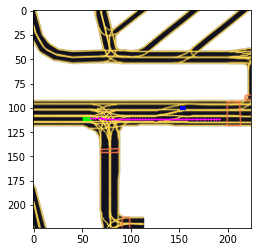

In [8]:
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

## What if I want to change the rasterizer?

We can do so easily by building a new rasterizer and new dataset for it. In this example, we change the value to `py_satellite` which renders boxes on an aerial image.

meta.json is not present in local data folder /home/herb/WRK/ken/data
!!dataset metafile not found!! the hard-coded matrix will be loaded.
This will be deprecated in future releases


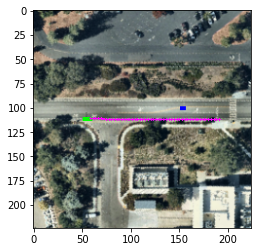

In [9]:
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

## What if I want to visualise an agent?

Glad you asked! We can just replace the `EgoDataset` with an `AgentDataset`. Now we're iterating over agents and not the AV anymore, and the first one happens to be the pace car (you will see this one around a lot in the dataset).

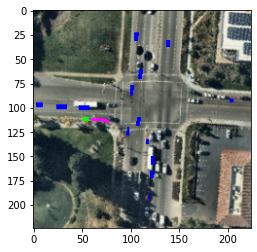

In [10]:
dataset = AgentDataset(cfg, zarr_dataset, rast)
data = dataset[0]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

## System Origin and Orientation

At this point you may have noticed that we flip the image on the **Y-axis** before plotting it.

When moving from 3D to 2D we stick to a right-hand system, where the origin is in the bottom-left corner with positive x-values going right and positive y-values going up the image plane. The camera is facing down the negative z axis. 

However, both `opencv` and `pyplot` place the origin in the top-left corner with positive x going right and positive y going down in the image plane. The camera is facing down the positive z-axis.

The flip done on the resulting image is for visualisation purposes to accommodate the difference in the two coordinate frames.

Further, all our rotations are counter-clockwise for positive value of the angle.

## How does an entire scene look like?

It's easy to visualise an individual scene using our toolkit. Both `EgoDataset` and `AgentDataset` provide 2 methods for getting interesting indices:
- `get_frame_indices` returns the indices for a given frame. For the `EgoDataset` this matches a single observation, while more than one index could be available for the `AgentDataset`, as that given frame may contain more than one valid agent
- `get_scene_indices` returns indices for a given scene. For both datasets, these might return more than one index

In this example, we visualise the second scene from the ego's point of view:

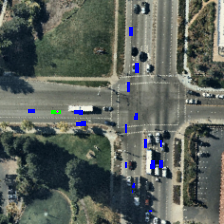

In [11]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 1
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    display(PIL.Image.fromarray(im[::-1]))